In [1]:
import sys
import os
from pathlib import Path

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

Internal imports   
The following cell ensures that the Python files in the `project_dir/code/` directory can be correctly imported by this notebook

In [2]:
# Add the project's `code` directory to the Python path
notebooks_dir = os.getcwd()
project_dir = os.path.dirname(notebooks_dir)
code_dir = os.path.join(project_dir, 'code')  
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

from my_utils import dict_from_disk, load_image_as_tensor
from cross_attention_dataset import CrossAttentionDataset
from probing_models import LinearProbe
from visualisation_utils import plot_masks_grid

Device

In [3]:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

Reproducibility

In [4]:
torch.manual_seed(0)
np.random.seed(0)

if DEVICE.type == 'cuda':
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Load cross-attention maps from disk

In [5]:
DATA_PATH = Path(r"C:\Users\aapolina\CODE\diffusion_segmentation\DATA\data\data\ECSSD_resized")

In [6]:
# Set the path to the directory containing the cross-attention maps
FEATURE_DIR = Path(f"{DATA_PATH}/features/cross_attn_cpu")

# Filter files in directory for the cross-attention maps
cross_attn_filenames = sorted([f for f in FEATURE_DIR.glob("*.h5") if f.stem.endswith("_cross")])

# Load the cross-attention maps
#list of 1000 samples, for each sample, first a dict with timestep keys, then for each timestep a dict with resolution keys
cross_attn_maps = [dict_from_disk(str(f)) for f in tqdm(cross_attn_filenames)] 


100%|██████████| 1000/1000 [00:27<00:00, 36.22it/s]


In [7]:
def map_norm(map):
    mean = map.mean(dim=(2, 3), keepdim=True)
    std = map.std(dim=(2, 3), keepdim=True)
    map = (map-mean)/std
    return

In [8]:
# cross_attn_maps_norm = cross_attn_maps.copy

# for i,sample in enumerate(cross_attn_maps):
#     print(sample.keys())
#     for ts in sample.keys():
#         print(sample[ts].keys())
#         for res in sample[ts].keys():

#             map = sample[ts][res]
#             print(map.shape)
#             cross_attn_maps_norm[i][ts][res] = map_norm(sample[ts][res])


In [9]:
GT_DIR = Path(f"{DATA_PATH}/gt")

# Load the ground truth masks for the cross-attention maps as (64, 64) tensors
base_names = map(lambda path: path.stem, cross_attn_filenames)
gt_paths = sorted([GT_DIR / f"{base_name.split('_')[0]}.png" for base_name in base_names])
gt_segmentations = [load_image_as_tensor(path, True) for path in gt_paths]

### Create a dataset and data loader from cross-attention maps

In [10]:
cross_attn_maps_train, cross_attn_maps_valid, gt_segmentations_train, gt_segmentations_valid = train_test_split(cross_attn_maps, gt_segmentations, test_size=0.2, random_state=0, shuffle=False)

In [73]:
dataset = CrossAttentionDataset(cross_attn_maps, gt_segmentations)

dataset_train = CrossAttentionDataset(cross_attn_maps_train, gt_segmentations_train)
data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)

dataset_valid = CrossAttentionDataset(cross_attn_maps_valid, gt_segmentations_valid)
data_loader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=True)

### Train model

In [74]:
model = LinearProbe(n_timesteps=len(dataset_train.timesteps)).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = torch.nn.BCELoss()

In [39]:
def store_weights(model):
    weights = []
    [weights.extend(v) for k,v in model.state_dict().items()]
    weights = [w.detach().cpu().numpy().tolist() for w in weights]
    return weights


In [13]:
def evaluate_training(model,loader, criterion):
    loss_valid = []
    with torch.no_grad():
        
        for  cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, gt in loader:
            cross_attn_8 = cross_attn_8.squeeze().to(DEVICE)
            cross_attn_16 = cross_attn_16.squeeze().to(DEVICE)
            cross_attn_32 = cross_attn_32.squeeze().to(DEVICE)
            cross_attn_64 = cross_attn_64.squeeze().to(DEVICE)
            gt = gt.to(DEVICE)
            output = model(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64).unsqueeze(0)


            loss = criterion(output, gt)
            loss_valid.append(loss.item())

    return loss_valid #np.mean(loss_valid)

In [75]:
losses_train = []
losses_valid = []

losses_train_all = []
losses_valid_all = []

all_weights = {}

for epoch in range(1):
    loss_epoch_train=[]
    all_weights[epoch] = {}

    with tqdm(data_loader_train, desc=f"Epoch {epoch}") as tepoch:
        iter=0
        for cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, gt in tepoch:
            cross_attn_8 = cross_attn_8.squeeze().to(DEVICE)
            cross_attn_16 = cross_attn_16.squeeze().to(DEVICE)
            cross_attn_32 = cross_attn_32.squeeze().to(DEVICE)
            cross_attn_64 = cross_attn_64.squeeze().to(DEVICE)
            gt = gt.to(DEVICE)

            optimizer.zero_grad()

            # Forward pass
            output = model(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64).unsqueeze(0)
            loss = criterion(output, gt)
            loss_epoch_train.append(loss.item())

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update the progress bar description
            tepoch.set_description(f"Epoch {epoch}")# Loss: {loss.item():.4f}")

            all_weights[epoch].update({iter: store_weights(model)})
            iter+=1

    loss_epoch_valid = evaluate_training(model, data_loader_valid, criterion)

    losses_train_all.append(loss_epoch_train) 
    losses_valid_all.append(loss_epoch_valid)
       
    loss_epoch_train = np.mean(loss_epoch_train)
    loss_epoch_valid = np.mean(loss_epoch_valid)

    losses_train.append(loss_epoch_train)
    losses_valid.append(loss_epoch_valid)  

    print(f"Epoch {epoch} \n Train Loss: {loss_epoch_train:.4f} \n Valid Loss: {loss_epoch_valid:.4f}")
    

Epoch 0: 100%|██████████| 800/800 [00:29<00:00, 27.30it/s]


Epoch 0 
 Train Loss: 0.3814 
 Valid Loss: 0.2934


<Axes: >

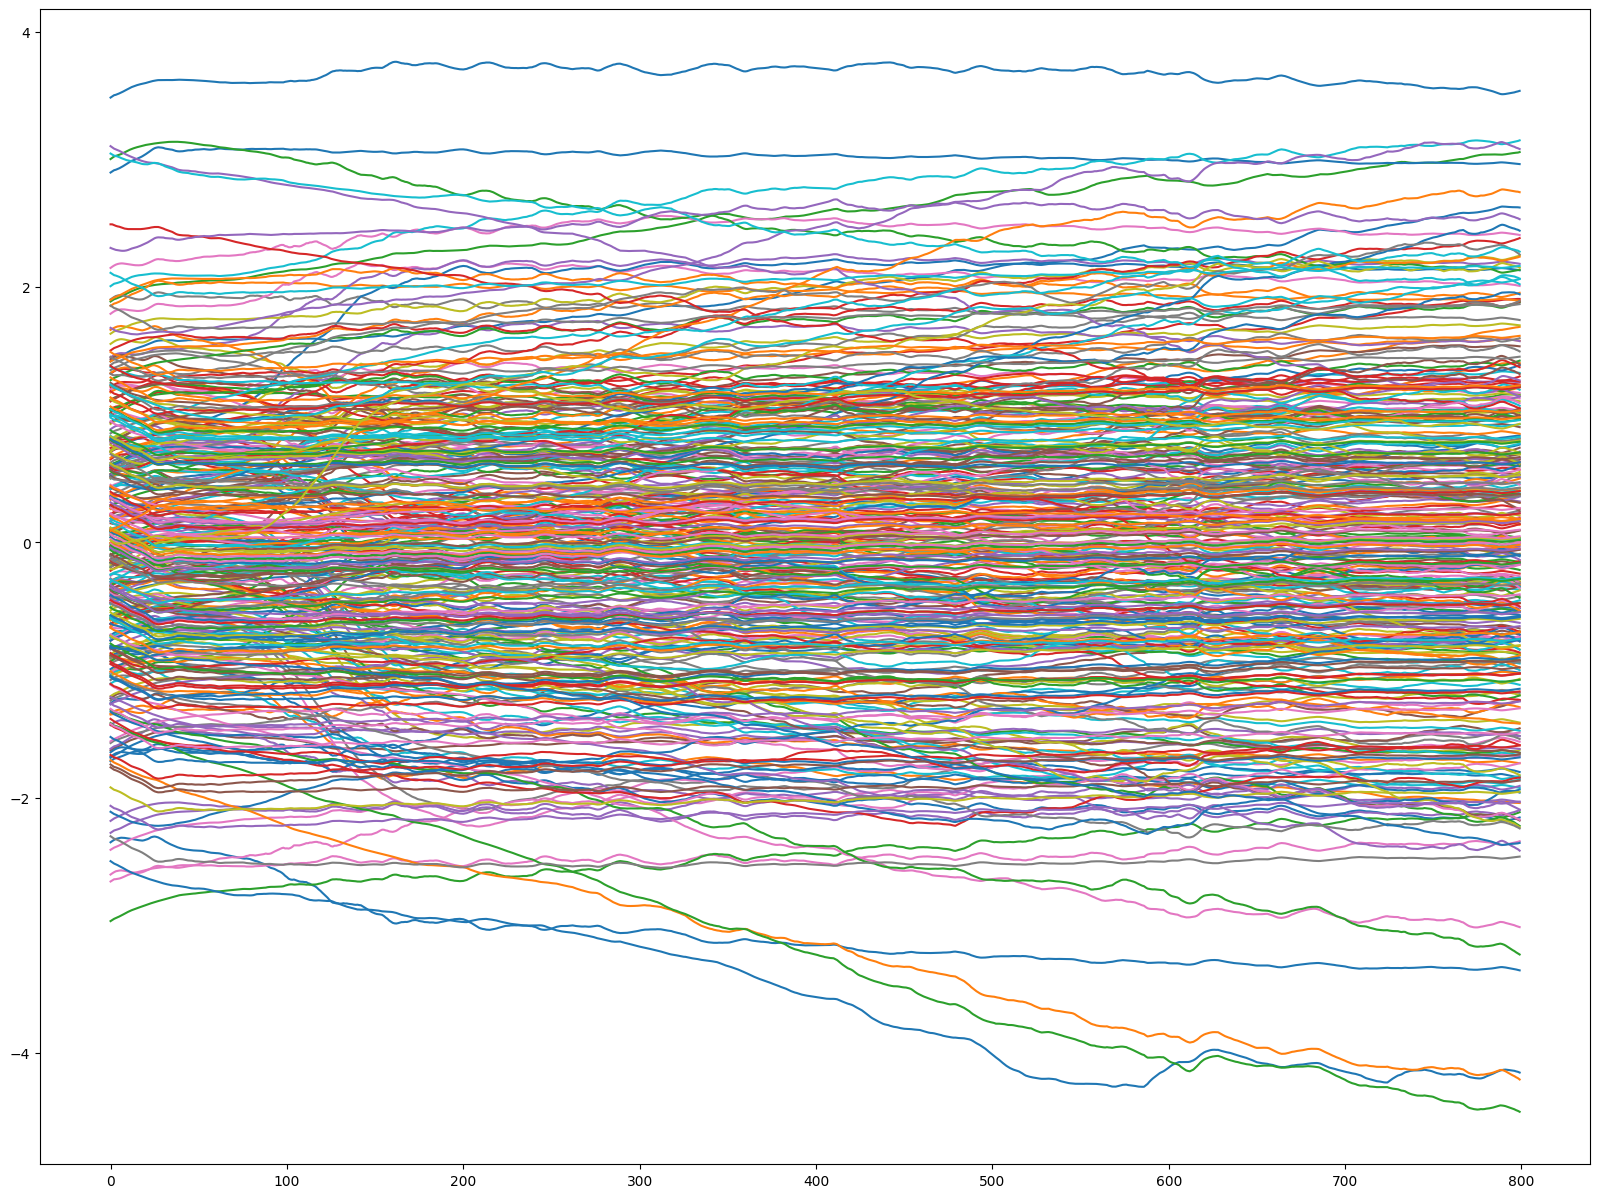

In [78]:
import pandas as pd
df = pd.DataFrame(data=all_weights[0])

df.T.plot(legend=False, figsize=(20,15))


In [76]:
new_weights = all_weights[0][0]


In [69]:
old_weights = all_weights[0][0]

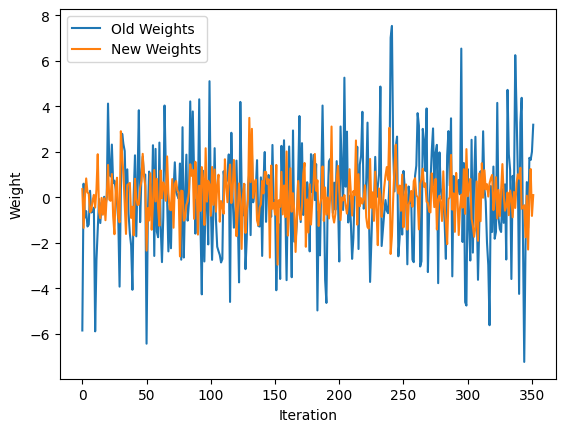

In [77]:
import matplotlib.pyplot as plt

# Plot the old_weights
plt.plot(old_weights, label='Old Weights')

# Plot the new_weights
plt.plot(new_weights, label='New Weights')

# Add labels and legend
plt.xlabel('Iteration')
plt.ylabel('Weight')
plt.legend()

# Show the plot
plt.show()


### Plot Train and Validation losses

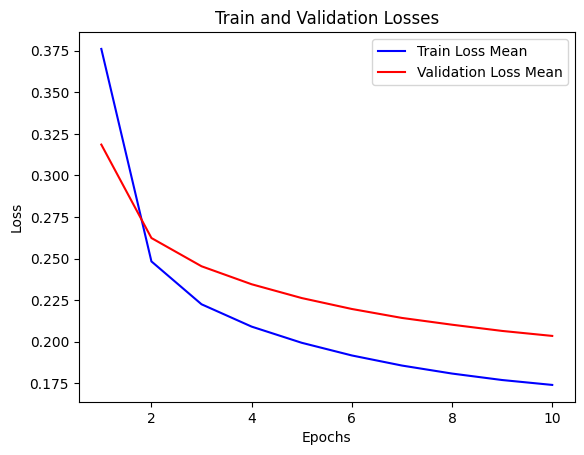

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, len(losses_train) + 1)

plt.plot(epochs, losses_train, 'b', label='Train Loss Mean')
plt.plot(epochs, losses_valid, 'r', label='Validation Loss Mean')
plt.title('Train and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

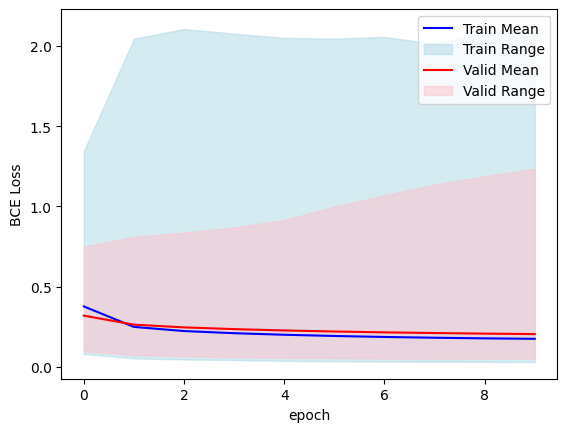

In [16]:
y_train = np.array(losses_train_all)
y_valid = np.array(losses_valid_all)

x = list(range(len(y_train)))
y_train_mean = np.mean(y_train, axis=1)
y_train_min = np.min(y_train, axis=1)
y_train_max = np.max(y_train, axis=1)
y_valid_mean = np.mean(y_valid, axis=1)
y_valid_min = np.min(y_valid, axis=1)
y_valid_max = np.max(y_valid, axis=1)

# Plot the line on the mean and shaded area of the range for training losses
plt.plot(x, y_train_mean, color='blue', label='Train Mean')
plt.fill_between(x, y_train_min, y_train_max, color='lightblue', alpha=0.5, label='Train Range')

# Plot the line on the mean and shaded area of the range for validation losses
plt.plot(x, y_valid_mean, color='red', label='Valid Mean')
plt.fill_between(x, y_valid_min, y_valid_max, color='pink', alpha=0.5, label='Valid Range')

# Add labels and legend
plt.xlabel('epoch')
plt.ylabel('BCE Loss')
plt.legend()

# Show the plot
plt.show()

In [17]:
def plot_img_output_gt(indices):

    fig, axs = plt.subplots(3, len(indices), figsize=(15, 5))

    for i, idx in enumerate(indices):
        img = load_image_as_tensor(gt_paths[idx].parent.parent / "img" / (gt_paths[idx].stem + ".jpg"))
        gt = load_image_as_tensor(gt_paths[idx], True)

        with torch.no_grad():
            cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, gt = dataset[idx]
            output = model(cross_attn_8.to(DEVICE), cross_attn_16.to(DEVICE),cross_attn_32.to(DEVICE), cross_attn_64.to(DEVICE))
            
            loss = criterion(output, gt.to(DEVICE)).cpu()
            output = output.squeeze().detach().cpu()

        axs[0, i].imshow(img.permute(1, 2, 0))
        axs[0, i].set_title(f"Image {idx}")

        axs[1, i].imshow(output)
        axs[1, i].set_title(f"Output {idx}: {loss:.4f}")

        axs[2, i].imshow(gt)
        axs[2, i].set_title(f"Ground Truth {idx}: {loss:.4f}")

    plt.tight_layout()
    plt.show()

Worst: [1.0701229572296143, 1.8249174356460571, 2.1255507469177246] [[493, 118, 537]]
Best: [0.029972517862915993, 0.032187264412641525, 0.03595183044672012] [[336, 300, 293]]


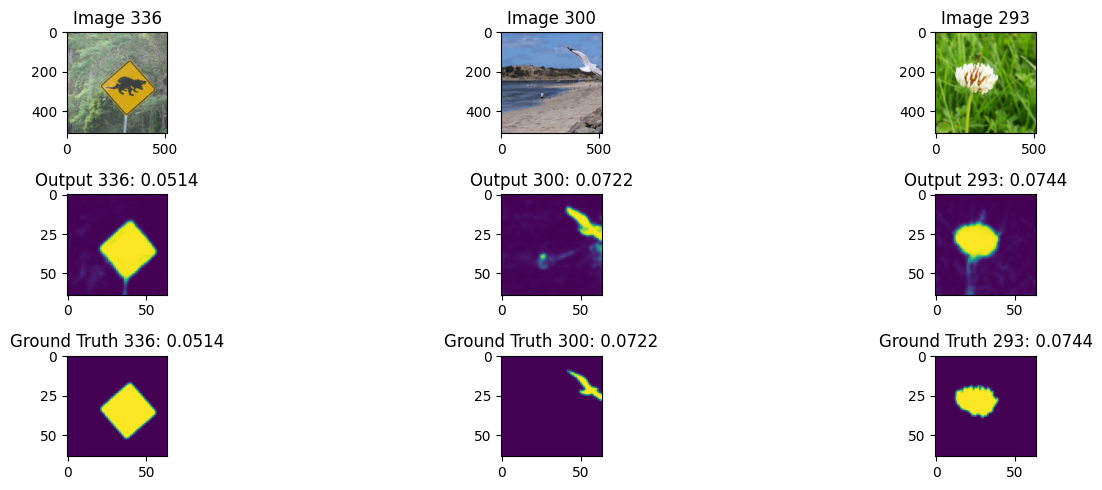

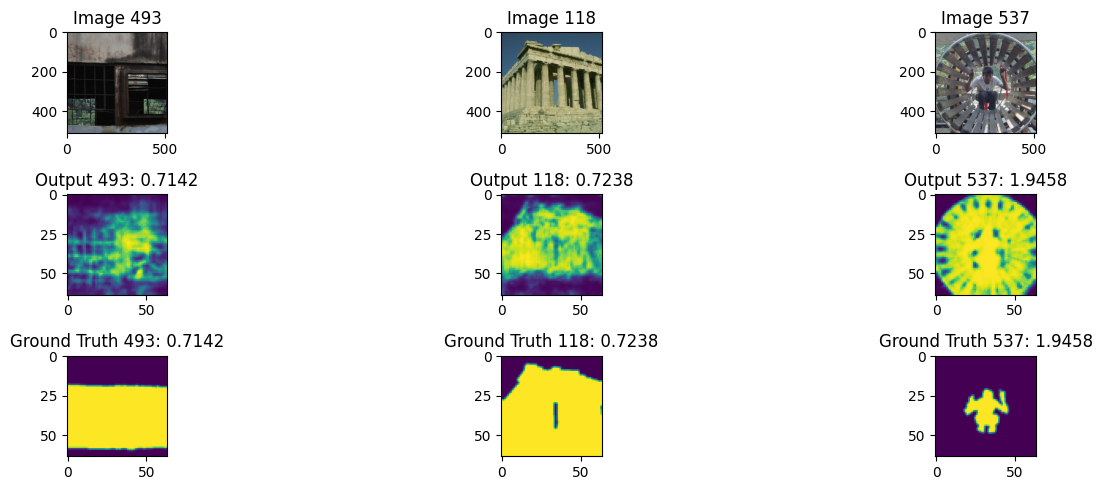

In [19]:
le = losses_train_all[9]
x = sorted(le)

best = [le.index(v) for v in  x[:3]]
worst = [le.index(v) for v in  x[-3:]]

print(f"Worst: {x[-3:]} [{worst}]\nBest: {x[:3]} [{best}]")

plot_img_output_gt(best)
plot_img_output_gt(worst)



In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)


352

# Save/Load the trained model to/from checkpoint

(saving the last state for now)

In [ ]:
checkpoint_path = os.path.join(os.getcwd(), 'cross_attn_experiment.ckpt')

In [ ]:
# save the model
torch.save(model.state_dict(), checkpoint_path)

In [ ]:
# load model from checkpoint
model = LinearProbe(n_timesteps=len(dataset_train.timesteps)).to(DEVICE)
model.load_state_dict(torch.load(checkpoint_path))

# Show the cross-attention maps

In [ ]:
model.to(DEVICE)
DEVICE

In [ ]:
idx =77

img = load_image_as_tensor(gt_paths[idx].parent.parent / "img" / (gt_paths[idx].stem + ".jpg"))
gt = load_image_as_tensor(gt_paths[idx], True)

with torch.no_grad():
    cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, _ = dataset[idx]
    cross_attn_8 = cross_attn_8.squeeze().to(DEVICE)
    cross_attn_16 = cross_attn_16.squeeze().to(DEVICE)
    cross_attn_32 = cross_attn_32.squeeze().to(DEVICE)
    cross_attn_64 = cross_attn_64.squeeze().to(DEVICE)
    gt = gt.to(DEVICE)
    output = model(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

img = img.cpu()
gt = gt.cpu()
output = output.cpu()   
output_binary = (output >= 0.5).float()


axs[0].imshow(img.permute(1, 2, 0))
axs[1].imshow(output)
axs[2].imshow(output_binary)
axs[3].imshow(gt, cmap='gray')



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_combined_image(image1, image2):
    combined_image = np.zeros((image1.shape[0], image1.shape[1], 3))

    # Set black pixels where both images have a value of 1
    combined_image[(image1 == 1) & (image2 == 1)] = [1,1,1]

    # Set white pixels where both images have a value of 0
    combined_image[(image1 == 0) & (image2 == 0)] = [0,0,0]

    # Set red pixels where the first image has a value of 1 and the second image has a value of 0
    combined_image[(image1 == 1) & (image2 == 0)] = [1, 0, 0]

    # Set green pixels where the first image has a value of 0 and the second image has a value of 1
    combined_image[(image1 == 0) & (image2 == 1)] = [0, 1, 0]

    plt.imshow(combined_image, cmap='gray')
    plt.axis('off')
    plt.show()


gt_binary = (gt>= 0.5).float()
plot_combined_image(output_binary, gt_binary)

In [ ]:
plot_masks_grid(cross_attn_64[0].cpu())

### Looking at the value ranges....

In [ ]:
def tensor_range(x):
    print(f"Ouput range: [{torch.min(x)}, {torch.max(x)}]")

In [ ]:
tensor_range(output)

In [ ]:
tensor_range(gt)

In [ ]:
map = cross_attn_64
map = model.instance_norm(map)
tensor_range(map)
torch.mean(map)
torch.std(map)

In [ ]:
def attn_maps_histograms(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64):
    fig, axs = plt.subplots(1,4, figsize=(10, 2.5))

    axs[0].hist(cross_attn_8.flatten(), bins=10)
    axs[0].set_title('cross_attn_8')

    axs[1].hist(cross_attn_16.flatten(), bins=10)
    axs[1].set_title('cross_attn_16')

    axs[2].hist(cross_attn_32.flatten(), bins=10)
    axs[2].set_title('cross_attn_32')

    axs[3].hist(cross_attn_64.flatten(), bins=10)
    axs[3].set_title('cross_attn_64')

    plt.tight_layout()
    plt.show()


In [ ]:
#attn_maps_histograms(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64)


In [ ]:
# x = cross_attn_64.flatten()
# tensor_range(x)

# x = torch.nn.functional.normalize(x, p=2, dim=0) #???
# tensor_range(x)

In [ ]:
# x = cross_attn_64
# x = torch.nn.BatchNorm2d(num_features=77)(x.cpu().float())
# tensor_range(x)
# x = x.reshape(10,77, 64*64).detach()
# torch.mean(x, dim=2)

In [ ]:
"""
https://pytorch.org/docs/stable/generated/torch.nn.InstanceNorm1d.html#torch.nn.InstanceNorm1d

"""
x = cross_attn_64
x = x.reshape(10,77, 64*64).detach()
x = torch.nn.InstanceNorm2d(num_features=77)(x.cpu().float())
tensor_range(x)
torch.mean(x.flatten())
torch.std(x.flatten())



In [ ]:
x = cross_attn_64

"""
https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d 

Input: (N,C,H,W)
num_features (int): C from an expected input of size (N,C,H,W)
Because the Batch Normalization is done over the C dimension, computing statistics on (N, H, W) slices, 
it’s common terminology to call this Spatial Batch Normalization.
"""

x = torch.nn.BatchNorm2d(num_features=77)(x.cpu().float())
x

In [ ]:
# x = cross_attn_64.cpu()
# x = x[0, 9]
# plt.imshow(x)

# x = cross_attn_64.cpu()
# x = x.flatten()
# x = x.reshape(10,77,64,64)
# x = x[0, 9]
# plt.imshow(x)


In [ ]:
#import torchsummary
#torchsummary.summary(model = model, input_size=[(10,77,8,8), (10,77,16,16), (10,77,32,32), (10,77,64,64)], batch_size=1, device='cuda')
#torchsummary.summary(model,[(10,77,8,8), (10,77,16,16), (10,77,32,32), (10,77,64,64)])

In [ ]:
plot_masks_grid(cross_attn_64[0].cpu())